*Riya Kalra*

# Summary of the SuSiE method

The SuSiE (Sum of Single Effects) method is a Bayesian fine-mapping approach designed to identify causal genetic variants while accounting for linkage disequilibrium (LD). Unlike traditional univariate regression, which can be confounded by LD, SuSiE models the genetic architecture as a sum of multiple independent effects, allowing it to detect multiple causal variants simultaneously. It produces *credible sets*, which represent groups of SNPs likely to contain causal variants, and assigns 
*posterior inclusion probabilities (PIP)* to each SNP to quantify its likelihood of being causal. By iteratively refining its estimates and incorporating LD structure, SuSiE provides a more robust and interpretable fine-mapping method compared to stepwise regression or single-SNP analysis. Its ability to efficiently scale to large GWAS datasets makes it a powerful tool for pinpointing genetic contributors to complex traits.


# Overview

This fine-mapping tutorial was developed using simulated data shipped with [`susieR`](https://github.com/stephenslab/susieR) package.
The simulated data contains simulated phenotype matrix $Y$ in $N \approx 600$ individuals. 
The goal is to identify from the genotype matrix $X_{N\times P}$ ($P=1000$) the genetic variables that directly cause changes in the phenotypic values.

**There are several questions throughout the notebook, and please answer each of them by adding cells (in Markdown or R) under the question and keep the code you use there as well.**

The simulated data-set is [available
here](https://github.com/stephenslab/susieR/blob/master/data/N3finemapping.RData),
as part of the `susieR` package. In this tutorial we will first explore the data with conventional univariate association analysis,
then perform preliminary fine-mapping analysis under simplified 
assumptions to illustrate the idea of statistical fine-mapping, and finally use the R package `susieR` to perform formal Bayesian fine-mapping analysis.
We will also discuss fine-mapping using association summary statistics.

# Explore the association data-set

First let's install the package `susieR` according to [its Github repo](https://github.com/stephenslab/susieR) and `corrplot` to draw some plots later. This may take a while.

In [ ]:
install.packages("susieR")
install.packages("corrplot")

Please execute the following code cell to load the simulated data.

In [2]:
rm(list=ls())
library(susieR)
library(corrplot)
data(N3finemapping)
attach(N3finemapping)

corrplot 0.95 loaded



In [3]:
ls()

[1] "N3finemapping"

The loaded dataset, `N3finemapping`, contains regression data $X$ and $Y$, 
along with some other relevant attributes in the context of genetic studies. It also
contains the "true" regression coefficients the data is simulated from.

In [4]:
names(N3finemapping)

[1] "X"                 "chrom"             "pos"              
[4] "true_coef"         "residual_variance" "Y"                
[7] "allele_freq"       "V"

In [5]:
dim(X)
head(X)

[1]  574 1001

-0.02090592,0.4738676,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,-0.2421603,0.1585366,-0.1567944,⋯,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,0.006059281,1.1689895,-0.2421603,1.1585366,-0.1567944,⋯,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,-0.026472457,1.1689895,-0.2421603,1.1585366,-0.1567944,⋯,0.5993031,-0.09254036,0.5880654,-0.2857143,-0.3885017,-0.3919861,0.6030205,-0.02090592,-0.2844549,-0.3883308
-0.02090592,0.4738676,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,-0.2421603,0.1585366,-0.1567944,⋯,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,-0.026472457,1.1689895,-0.2421603,1.1585366,-0.1567944,⋯,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,0.7578397,0.1585366,-0.1567944,⋯,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308


-----------------------------------------

**Example question: in the genotype matrix `X`, how many individuals and the genetic variants are included? What is the genotype value for the 100th variant of the 21st individual?**

**Example answer:** The genotype matrix has 574 individuals and 1001 genetic variants. The genotype value for the 100th variant of the 21st individual is 0.4408.

In [6]:
dim(X)

[1]  574 1001

In [7]:
X[21, 100]

[1] 0.4407666

-----------------------------------------

The phenotype matrix contains values for the 574 individuals for 2 traits,

In [8]:
dim(Y)

[1] 574   2

We focus on the first trait, let

In [9]:
y = Y[,1]
b = true_coef[,1]

There are 3 "causal" variants for this trait,

In [10]:
which(b != 0)

[1] 403 653 773

Note: in this tutorial we will avoid the phrase "causal", and use "effect variable" to refer to the variants having true non-zero effects on the phenotype.

-----------------------------------------

**Question 1: Please use R function `plot` to visualize the true effects vector. What are the effect sizes for these 3 "causal" variants?**

**Answer:**

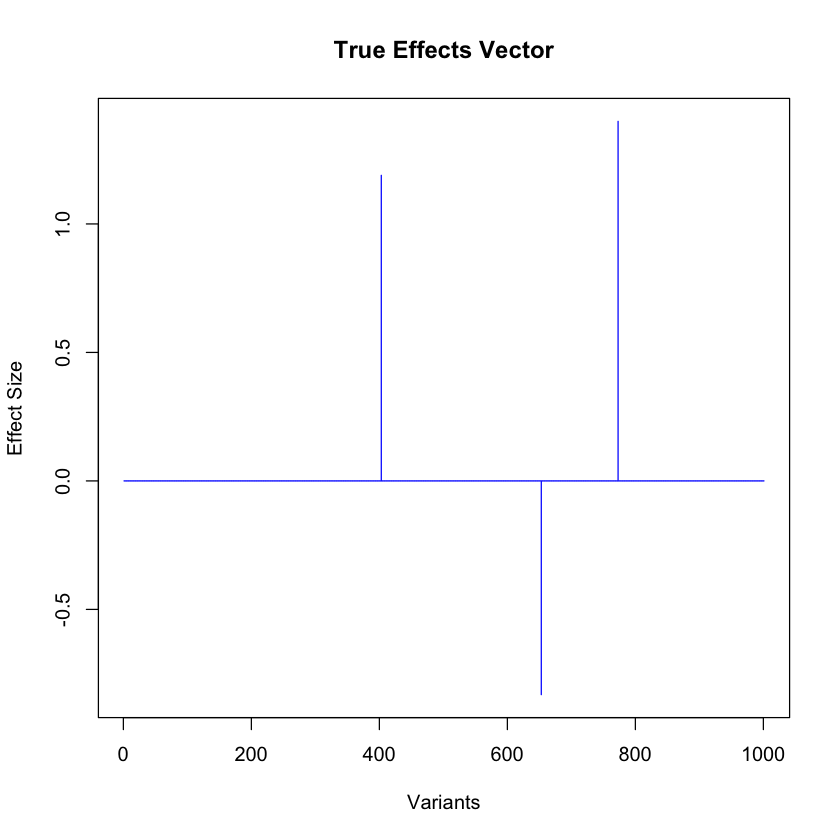

In [11]:
plot(b, type = "h", main = "True Effects Vector", xlab = "Variants", ylab = "Effect Size", col = "blue")

In [12]:
causal_indices <- which(b != 0)  # Indices of causal variants
effect_sizes <- b[causal_indices]
print(effect_sizes)

[1]  1.189172 -0.831789  1.399288


-----------------------------------------

# Association testing via simple linear regression

`univariate_regression` function in `susieR` can be used to perform association testing 
by fitting univariate simple regression for each variable separately.
The results are $\hat{\beta}$ for effect size estimates, and their standard errors $SE(\hat{\beta})$.

In [13]:
sumstats <- univariate_regression(X, y)

-----------------------------------------

**Question 2: Please use R function plot to compare the true effects variable `b` with the estimated effect sizes `sumstats$betahat`. Are they consistent, and why?**

**Answer:**

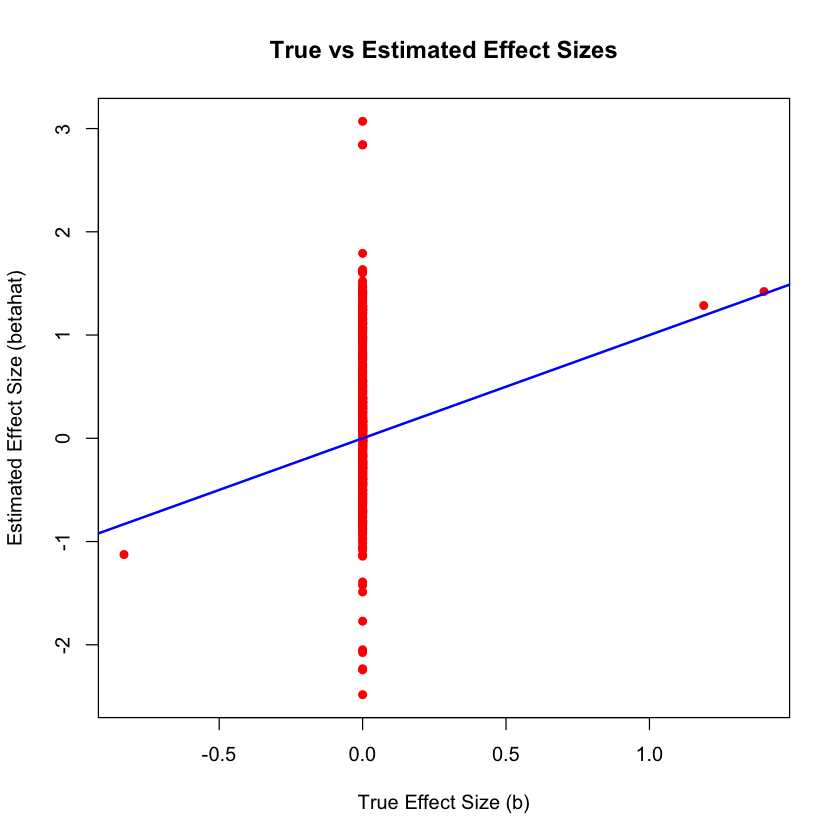

In [14]:
plot(b, sumstats$betahat, main = "True vs Estimated Effect Sizes",
     xlab = "True Effect Size (b)", ylab = "Estimated Effect Size (betahat)", col = "red", pch = 16)
abline(0,1, col="blue", lwd=2)  # Reference line

Points are clustered around 0 on the x-axis, meaning most variants have a true effect of 0 (i.e., they are non-causal). Some points deviate significantly from the identity line (y = x), meaning estimated effect sizes (betahat) do not always align with their true values. A few extreme outliers exist, where estimated effect sizes are much larger than expected. The blue reference line (y = x) suggests a general trend, but there is considerable noise.

*Interpretation:*

The estimated effect sizes (betahat) are not perfectly consistent with the true effect sizes (b). The cluster of points around 0 on the x-axis but spread on the y-axis suggests that many non-causal variants have non-zero estimated effects, likely due to statistical noise or linkage disequilibrium (LD). The few points aligning with the blue y = x line are likely true causal variants whose effects have been correctly estimated. The vertical spread at b = 0 suggests that many SNPs with no real effect still get nonzero estimates, which is expected due to sampling variance in GWAS.

-----------------------------------------

z-scores can be derived from these quantities; $-log_{10}$ p-values can then becomputed from z-scores, 

In [15]:
z_scores <- sumstats$betahat / sumstats$sebetahat
log10p <- -log10(pchisq(z_scores^2,1,lower.tail=F))

-----------------------------------------

**Question 3: How many variables have p-values smaller than $5 \times 10^{-8}$? How would you interpret those variants based on the univariate association analysis?**


**Answer:**

In [16]:
p_values <- pchisq(z_scores^2, 1, lower.tail=F)
significant_count <- sum(p_values < 5e-8)
print(significant_count)

[1] 8


8 variants. These SNPs reach genome-wide significance, suggesting that they have strong statistical evidence for association with the trait. Based on the univariate association analysis, these variants may be causal or in linkage disequilibrium (LD) with true causal variants. Further fine-mapping analysis is needed to distinguish true causal SNPs from correlated ones.

**Question 4: What's the correlation between these variables (with p-values smaller than $5 \times 10^{-8}$) in the original genotype data `X`? Draw a correlogram and print out the pair with highest positive correlation. What does it mean for those two variants?**

In [17]:
significant_indices <- which(p_values < 5e-8)  # Find indices of significant SNPs
X_significant <- X[, significant_indices]  # Subset genotype matrix for these variants
cor_matrix <- cor(X_significant) # Compute pairwise correlations

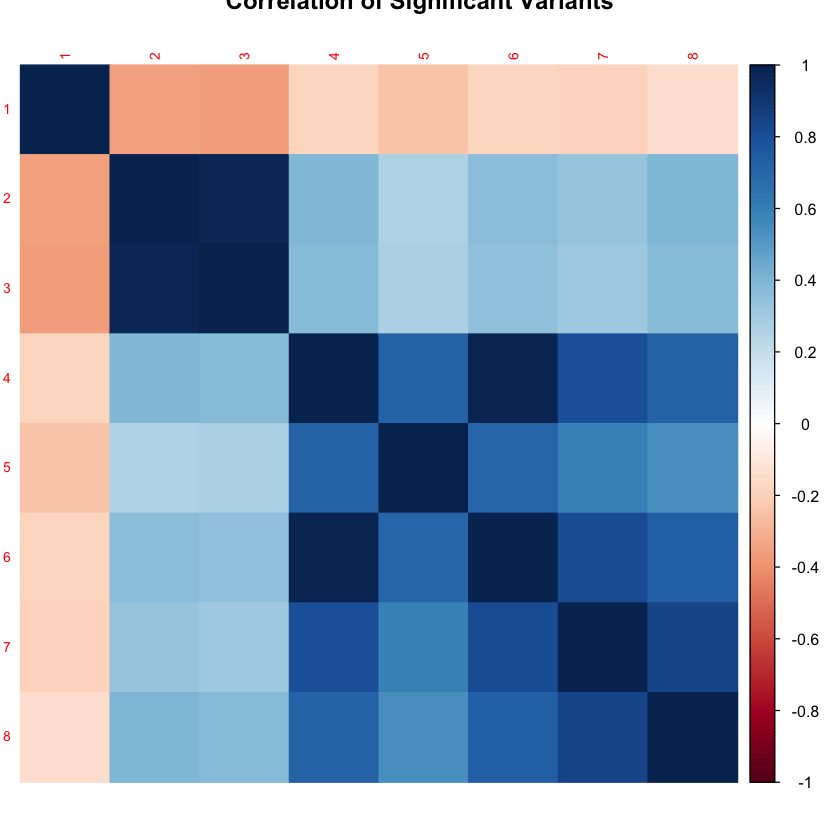

In [18]:
library(corrplot)
corrplot(cor_matrix, method = "color", tl.cex = 0.7, title = "Correlation of Significant Variants")
# Remove diagonal values and keep only upper triangle to avoid duplicate pairs
cor_matrix[lower.tri(cor_matrix, diag=TRUE)] <- NA 

In [19]:
# Find the pair with the highest correlation (excluding diagonal)
max_cor_indices <- which(cor_matrix == max(cor_matrix, na.rm=TRUE), arr.ind=TRUE)
print(max_cor_indices)  # SNP indices with highest correlation

     row col
[1,]   4   6


**Answer:**

[4, 6]: Their correlation is close to 1.0, suggesting they are in strong linkage disequilibrium. This means they tend to be inherited together, and one of them may be tagging the causal variant rather than being independently causal.

-----------------------------------------

`susieR` package provides a plot function to generate Manhattan plot for the association test results. Notice that the true effect variables are labelled in red (true effects provided to `susie_plot` via setting `b=` parameter),

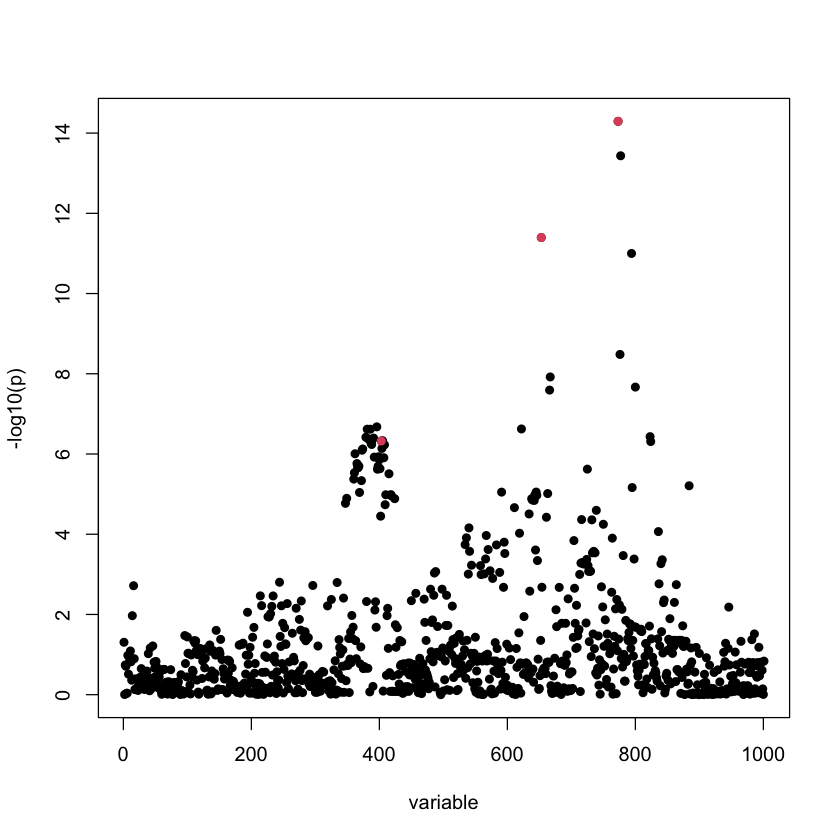

In [20]:
susie_plot(z_scores,y="z",b=b)

As shown on this plot, the "lead" SNP (the one with smallest p-value) is indeed one of the true effect variables. However, the 2nd most significant SNP is not one of the other two effect variables, and there are many other SNPs having p-values smaller than $5 \times 10^{-8}$, a widely accepted significant level threshold for genetic association studies.

-----------------------------------------

**Question 5: What index is the second most significant SNP? Is it one of the other two true effect variables? What would you say about the relationship between the top and 2nd most significant SNPs?**


**Answer:**

In [21]:
sorted_indices <- order(p_values)  # Sort SNPs by increasing p-value
lead_snp_index <- sorted_indices[1]  # Most significant SNP
second_snp_index <- sorted_indices[2]  # Second most significant SNP
print(second_snp_index)  # Output index of 2nd most significant SNP

[1] 777


In [22]:
causal_indices <- which(b != 0)  # Indices of true effect variables
is_causal <- second_snp_index %in% causal_indices
print(is_causal)  # TRUE or FALSE

[1] FALSE


The second most significant SNP is at index 777, and it is not one of the other two true causal variants. This suggests that it may be in linkage disequilibrium (LD) with the causal SNP, rather than being causal itself. Since multiple SNPs have p-values below the significance threshold, further fine-mapping or conditional analysis is needed to identify independent signals.

-----------------------------------------

# "One causal variant" assumption for fine-mapping

Under the assumption that there is only one true effect in the region of interest, fine-mapping does not have to use linkage disequilibrium (LD) information between variables. It can be performed by simply calculating the likelihood of the association model for each variable separately, then computing the probability for a variable being the true effect as the ratio of its likelihood over the sum of likelihoods over all variables. We use linear regression `lm` in R to compute the log-likelihood,

In [23]:
lliks = sapply(1:ncol(X), function(i) logLik(lm(y~X[,i])))

Then compute the probability for each variable being the true effect variable: 

In [24]:
lliks = lliks - max(lliks) # To avoid taking exp on large numbers in the next line, thus improving numerical stability 
probs = exp(lliks)/sum(exp(lliks))

We use `susie_plot` function to plot these probabilities computed, and color label the true effect variables:

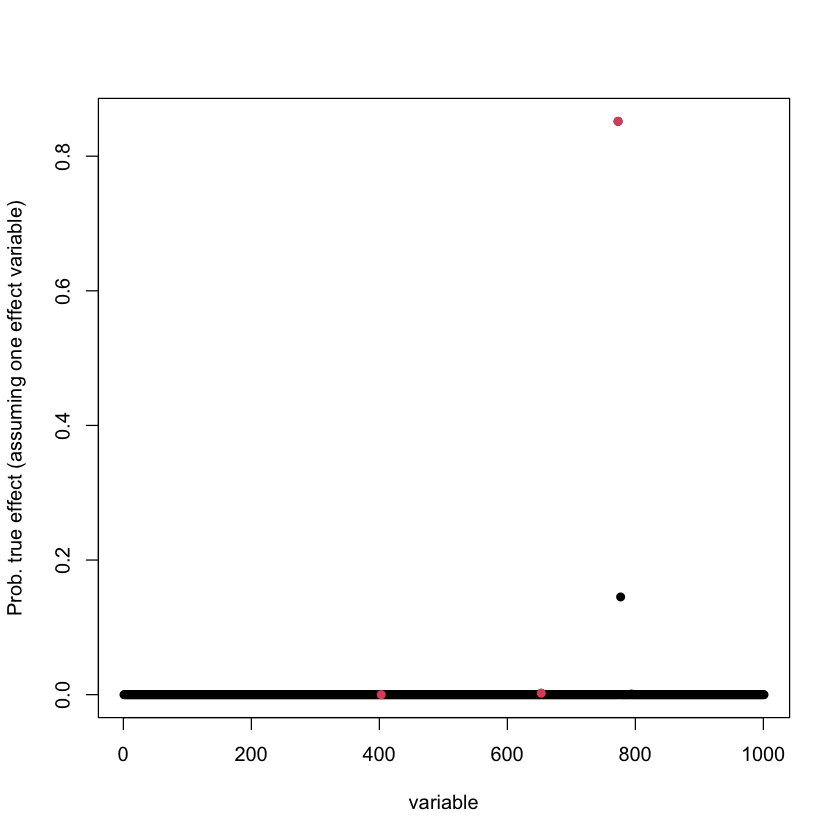

In [25]:
susie_plot(probs, y="PIP", b=b, ylab = "Prob. true effect (assuming one effect variable)")

As expected, under the "one causal variant" assumption, only the lead SNP is identified with over 80% probability of having a non-zero effect. The other two true effect variables in red are not identified.

## 95% credible set for single effect

95% credible set (CS) is defined as a set of variables with 95% probability of containing a true effect. By visually examine the plot above, we can see that the lead SNP has over 80% probability being the true effect, and another SNP near it has almost 20% probability of being the true effect. The 95% credible set should thus contain both of them in order for the coverage to exceed 95%. Indeed, we can formally verify this using an internal function `in_CS` to assess if a variable is in a single effect CS. We report the indices of these variables,

In [26]:
which(susieR:::in_CS(t(probs), coverage = 0.95) != 0)

[1] 773 777

These variables indeed correspond to the two non-zero probability variables on the plot above.

# Fine-mapping with individual level data using Sum of Single Effects model

When multiple true effects are expected, formal statistical fine-mapping via Bayesian Variable Selection
should be performed. We fit a Sum of Single Effects (SuSiE) model implemented in `susieR` package, 
assuming at most 10 causal variables (although SuSiE is robust to the choice of `L`).

In [27]:
fitted <- susie(X, y, L = 10)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



## 95% credible sets for each single effect

By default, `susie` function computes 95% CS each containing one effect variable,

In [28]:
print(fitted$sets)

$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 362 365 372 373 374 379 381 383 384 386 387 388 389 391 392 396 397 398 399
[20] 400 401 403 404 405 407 408 415


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8686309     0.9640176       0.9720711

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9539811

$requested_coverage
[1] 0.95



The 3 true signals have been captured by the 3 CS reported here. The
3rd CS contains many variables, including the true causal variable
`403`. The minimum absolute correlation is 0.86.

-----------------------------------

**Question 6: Print the credible sets if we use 99% as the coverage. Hint: you may want to check the source code for `susie` function from [here](https://github.com/stephenslab/susieR)**.

**Answer:**

In [29]:
# Fit the SuSiE model
susie_fit <- susie(X, y, L = 10, coverage = 0.99)

# Extract credible sets
credible_sets <- susie_fit$sets
print(credible_sets)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 360 361 362 365 366 367 368 372 373 374 379 381 383 384 386 387 388 389 391
[20] 392 396 397 398 399 400 401 403 404 405 407 408 409 410 415 419


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8310851     0.9499450       0.9556871

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9906629

$requested_coverage
[1] 0.99



In [30]:
for (i in seq_along(credible_sets$cs)) {
  cat("Credible Set", i, ":", credible_sets$cs[[i]], "\n")
}

Credible Set 1 : 653 
Credible Set 2 : 773 777 
Credible Set 3 : 360 361 362 365 366 367 368 372 373 374 379 381 383 384 386 387 388 389 391 392 396 397 398 399 400 401 403 404 405 407 408 409 410 415 419 


**Question 7: does higher coverage mean you have larger CS, or smaller CS? Why is that? Please look at the 3rd CS as an example in the two fitted results, and explain why the minimum absolute correlation is lower when the coverage is higher?**

**Answer:**

Higher coverage leads to larger credible sets (CS).

Higher coverage (e.g., 99%) means we are capturing more of the probability mass, so we include more SNPs.
Lower coverage (e.g., 90%) is stricter, meaning fewer SNPs are needed to reach the threshold.

Higher coverage results in larger credible sets because more SNPs are needed to achieve the probability threshold. In the 3rd credible set, the minimum absolute correlation is lower at 99% coverage because additional SNPs with weaker correlations are included to maintain the higher probability coverage.

-----------------------------------

## Posterior inclusion probabilities

Here we summarize the fine-mapping results by posterior inclusion
probability (PIP):

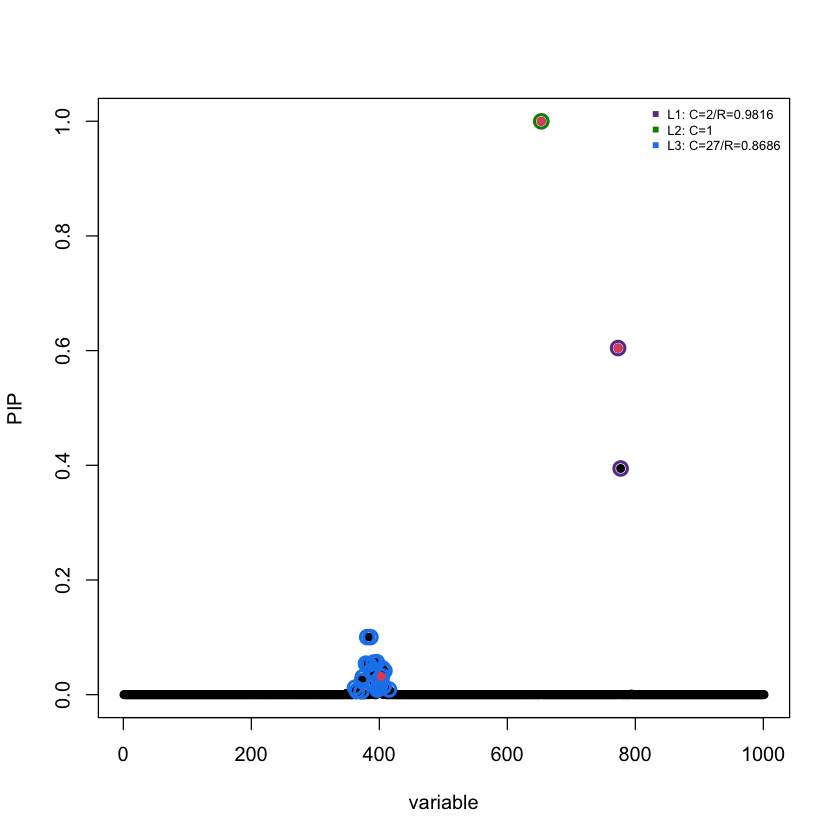

In [31]:
susie_plot(fitted, y="PIP", b=b, add_legend=T)

The true effect variables are colored red, and the three 95% CS identified are
circled in different colors. 

-------------------------------------------

**Question 8: Recall the true effect variables we know before running any susie, and for the variable 403, what is the PIP? What's the average PIP of the 3rd CS? Is the PIP for variable 403 higher or lower than the average, and why is that?**

Hint: You can use the code below to compare $-log_{10}$ p-value and PIP for the CS containing variable 403:

```R
    i  <- fitted$sets$cs$L3
    z3 <- cbind(i,log10p[i],fitted$pip[i])
    colnames(z3) <- c('position', '-log10 pvalue', 'PIP')
    z3[order(z3[,2], decreasing = TRUE),]
```

**Answer:**

In [32]:
# Extract PIP value
pip_403 <- susie_fit$pip[403]
print(pip_403)

[1] 0.03199285


In [33]:
# Compute average PIP
cs3_indices <- susie_fit$sets$cs[[3]]  # Get indices of SNPs in CS3
avg_pip_cs3 <- mean(susie_fit$pip[cs3_indices])
print(avg_pip_cs3)


[1] 0.02830467


In [34]:
# Compare PIP for Variable 403 vs. CS3 Average
if (pip_403 > avg_pip_cs3) {
    cat("PIP for variable 403 is higher than the average PIP of CS3.\n")
} else {
    cat("PIP for variable 403 is lower than the average PIP of CS3.\n")
}


PIP for variable 403 is higher than the average PIP of CS3.


In [35]:
# Check p-values and PIP for All SNPs in CS3
i  <- susie_fit$sets$cs[[3]]  # Get 3rd credible set
z3 <- cbind(i, log10p[i], susie_fit$pip[i])
colnames(z3) <- c('position', '-log10 pvalue', 'PIP')
z3 <- z3[order(z3[,2], decreasing = TRUE),]  # Sort by p-value
print(z3)


      position -log10 pvalue         PIP
 [1,]      396      6.676732 0.056704331
 [2,]      381      6.618518 0.100360243
 [3,]      386      6.618518 0.100360243
 [4,]      379      6.417587 0.054179507
 [5,]      391      6.396640 0.055952118
 [6,]      383      6.370810 0.052896918
 [7,]      384      6.370810 0.052896918
 [8,]      389      6.360493 0.042161265
 [9,]      405      6.331181 0.045761975
[10,]      403      6.322861 0.031992848
[11,]      387      6.272121 0.041041505
[12,]      388      6.237010 0.039650079
[13,]      408      6.230055 0.041551961
[14,]      404      6.139356 0.032013339
[15,]      374      6.125189 0.030571484
[16,]      373      6.094780 0.023577221
[17,]      362      6.005750 0.012145481
[18,]      399      5.932096 0.026454056
[19,]      392      5.922454 0.019741011
[20,]      407      5.906902 0.014699313
[21,]      400      5.859007 0.021659443
[22,]      365      5.762214 0.006263425
[23,]      368      5.698002 0.005452872
[24,]      398  

The PIP for variable 403 is 0.03199285, and the average PIP for the 3rd credible set is 0.02830467. The PIP for variable 403 is higher than the average because the variable is more strongly supported by fine-mapping as a likely causal variant.

***

**Question 9: Please rerun the `susie` analysis setting `L=1` to detect a maximum of only one effect across the region. How does the result compare to the previous section of "one causal effect" fine-mapping using likelihoods from univariate analysis?**

**Answer:**

In [36]:
# Fit SuSiE allowing only one causal effect
susie_L1 <- susie(X, y, L = 1, coverage = 0.99)

# Print the credible set
print(susie_L1$sets)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



$cs
$cs$L1
[1] 773 777


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L1    0.9815726     0.9815726       0.9815726

$cs_index
[1] 1

$coverage
[1] 0.9968218

$requested_coverage
[1] 0.99



In [37]:
lliks = sapply(1:ncol(X), function(i) logLik(lm(y ~ X[, i])))
probs = exp(lliks - max(lliks)) / sum(exp(lliks))

In [38]:
pip_L1 <- susie_L1$pip
lead_snp_L1 <- which.max(pip_L1)  # SNP with highest PIP
print(lead_snp_L1)

[1] 773


When setting L=1 in SuSiE, the method identifies only one causal variant. The result is similar to the likelihood-based fine-mapping, as both methods highlight the strongest association. However, unlike the univariate likelihood approach, SuSiE accounts for linkage disequilibrium (LD), meaning it may select a different SNP that represents the same signal. If multiple true effects exist, this assumption underestimates the number of causal variants.

-------------------------------------------

## Choice of prior effect size

In SuSiE, the prior effect size is parameterized by the percentage of variance explained by a variable, $h_j^2$. 
By default, SuSiE estimates $h_j^2$ and uses it as the prior (an empirical Bayes approach). 
Here we demonstrate fixing the prior effect size to 0.2, i.e., we believe a non-zero effect variable can explain 20% variation in quantitative trait values:

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



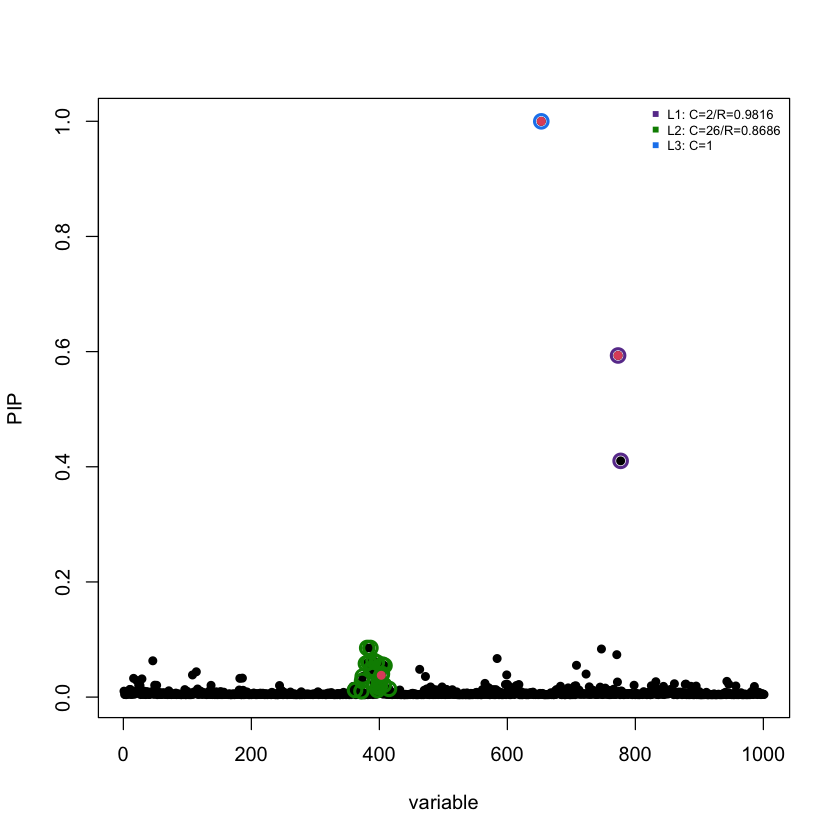

In [39]:
fitted2 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.2)
susie_plot(fitted2, y='PIP', b=b, add_legend=T)

The result is very similar to when prior effects are estimated. 

-------------------------------------------

**Question 10: Please change `scaled_prior_variance` to different numbers between 0 and 1, and examine the results. What happens if you set it to 0.001, and why?**

**Answer:**

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



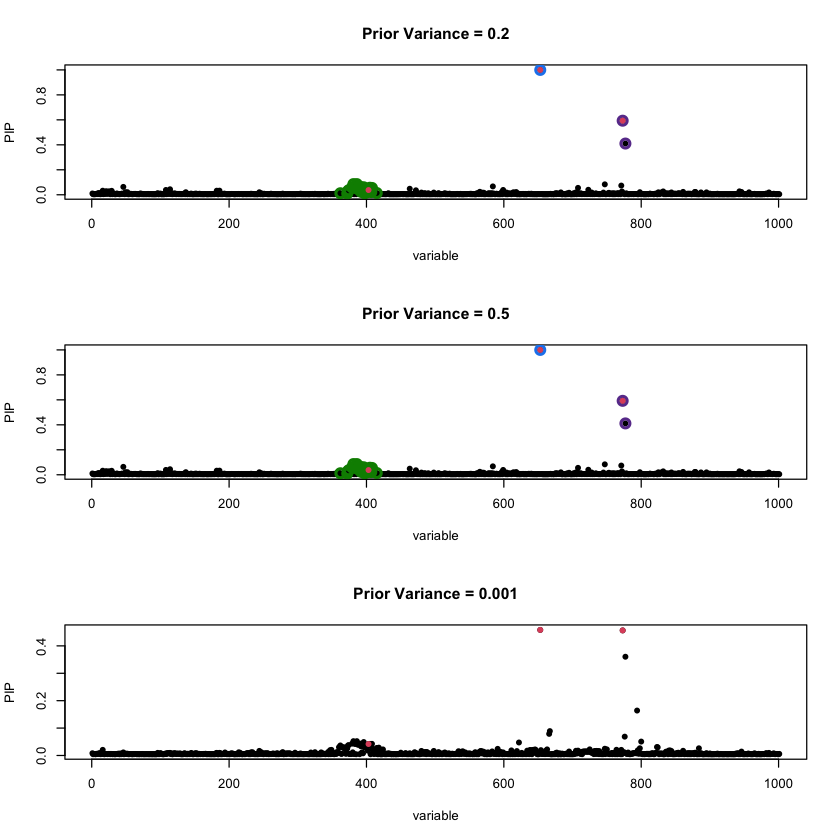

In [40]:
# Test different prior effect sizes
fitted_02   <- susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.2)
fitted_05   <- susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.5)
fitted_001  <- susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.001)

# Plot comparisons
par(mfrow=c(3,1))  # Arrange plots in one column
susie_plot(fitted_02, y="PIP", b=b, main="Prior Variance = 0.2")
susie_plot(fitted_05, y="PIP", b=b, main="Prior Variance = 0.5")
susie_plot(fitted_001, y="PIP", b=b, main="Prior Variance = 0.001")

In [41]:
fitted_001 <- susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.001)
print(fitted_001$sets)  # Check credible sets


HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



$cs
NULL

$coverage
NULL

$requested_coverage
[1] 0.95



When scaled_prior_variance = 0.001, SuSiE assumes that each SNP explains very little variance, leading to lower PIP values and fewer credible sets. This makes the model overly conservative, reducing its ability to detect true causal variants. A moderate prior variance (e.g., 0.2 or 0.5) provides better fine-mapping results.

-------------------------------------------

# Fine-mapping with summary statistics via `susie_rss`

Summary statistics of genetic association studies typically contain effect size ($\hat{\beta}$ coefficient from regression), p-value and minor allele frequencies. 
These information can be used to perform fine-mapping with given an additional input of correlation matrix between variables.
The correlation matrix in genetics is typically referred to as LD matrix (LD for linkage disequilibrium). 
One may use external reference panels to estimate it when this matrix cannot be obtained from samples directly. There is a potential problem using LD from reference panel, and we demonstrated it in the next section.
Caution that LD matrix here has to be correlation matrix $r$, not $r^2$ or $|r|$.

We have previously computed z-scores for this data-set. The correlation matrix can be computed directly from $X$ matrix, 

In [42]:
R <- cor(X)

SuSiE regression with summary statistics is implemented as `susie_rss` function, 

In [43]:
fitted_rss <- susie_rss(z_scores, R, L = 10)


HINT: For large R or large XtX, consider installing the Rfast package for better performance.



We compare the PIP obtained with previous analysis using individual level data,

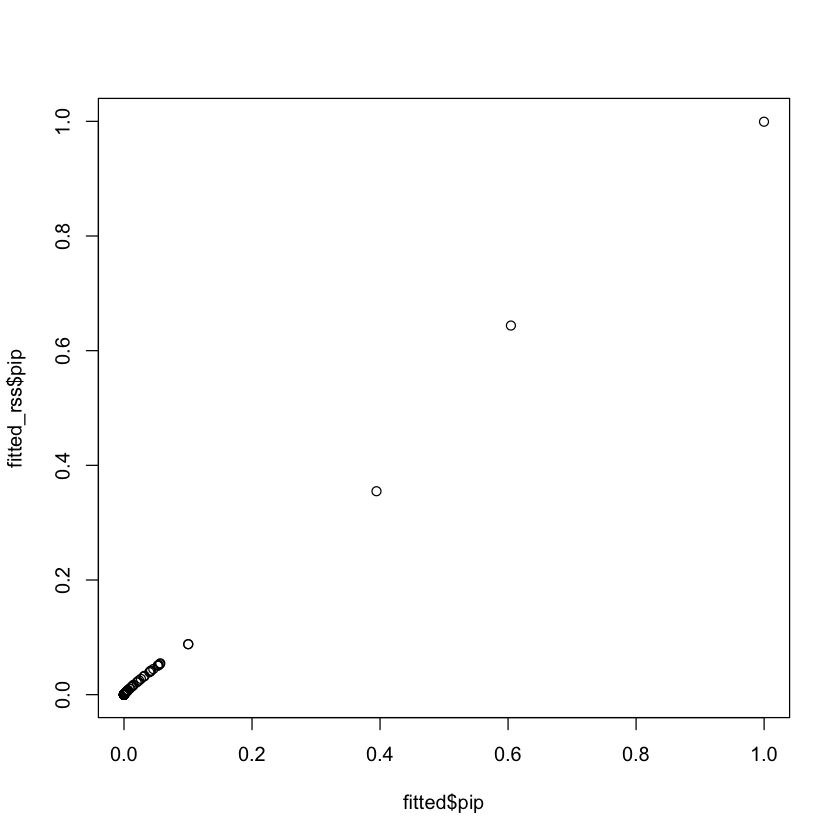

In [44]:
plot(fitted$pip, fitted_rss$pip, ylim=c(0,1))

The results very much agree. This is expected when the summary statistics are indeed derived from the individual level data.

## Use LD from external reference data

When original genotype information is not available, 
one may use reference panel to estimate LD matrix. 
False discoveries may occur if the LD pattern from the reference panel does not agree well with the original sample. 

To illustrate, we randomly generated 500 samples from $N(0,R)$ and treated them as reference panel genotype matrix `X_ref`.

In [45]:
set.seed(1234)
tmp = matrix(rnorm(500*1001), 500, 1001)
eigenR = eigen(R)
eigenR$values[eigenR$values < 1e-10] = 0
X_ref = tmp %*% (eigenR$values * t(eigenR$vectors))
R_ref = cor(X_ref)

Using `susie_rss` function with LD from reference panel,


HINT: For large R or large XtX, consider installing the Rfast package for better performance.



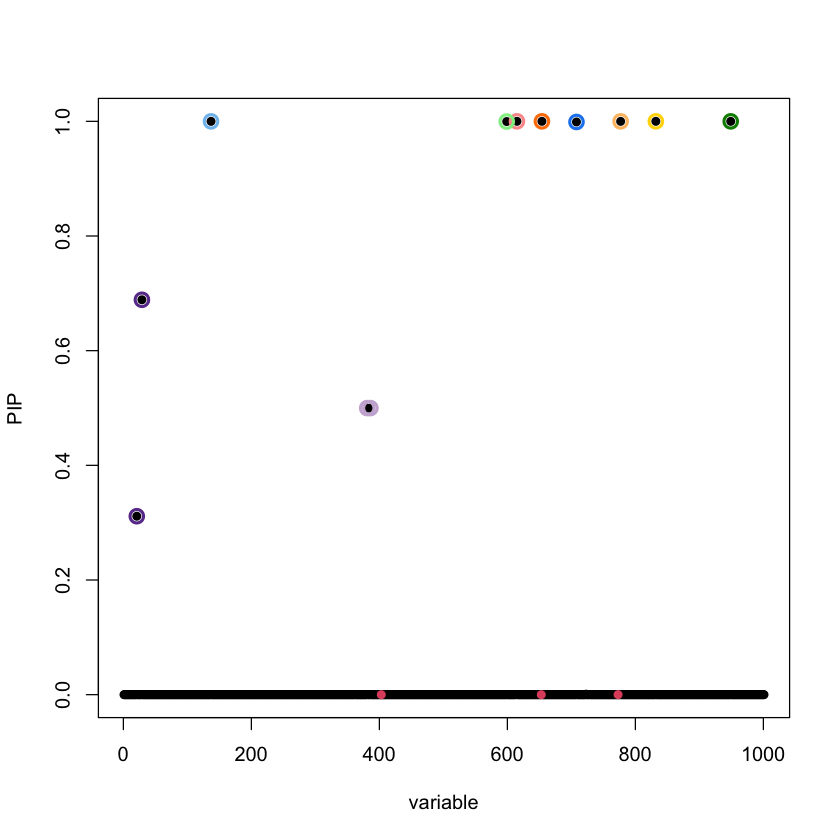

In [46]:
fitted_rss_ref <- susie_rss(z_scores, R_ref, L = 10)
susie_plot(fitted_rss_ref, y="PIP", b=b)

-------------------------------------------

**Question 11: Please compare and comment on the CS reported using reference LD panel versus using the correct LD computed from genotype data. Are there any false discoveries?**

**Answer:**

In [47]:
# Extract credible sets
cs_true <- fitted_rss$sets
cs_ref <- fitted_rss_ref$sets

# Print summary
print(cs_true)  # CS with true LD
print(cs_ref)   # CS with reference LD

$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 360 362 365 368 372 373 374 379 381 383 384 386 387 388 389 391 392 396 397
[20] 398 399 400 401 403 404 405 407 408 415


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8310851     0.9571059       0.9674829

$cs_index
[1] 2 1 3

$coverage
[1] 0.9993272 0.9986467 0.9508572

$requested_coverage
[1] 0.95

$cs
$cs$L1
[1] 777

$cs$L2
[1] 381 386

$cs$L3
[1] 599

$cs$L4
[1] 615

$cs$L5
[1] 137

$cs$L6
[1] 832

$cs$L7
[1] 654

$cs$L9
[1] 949

$cs$L10
[1] 708

$cs$L8
[1] 21 29


$purity
    min.abs.corr mean.abs.corr median.abs.corr
L1     1.0000000     1.0000000       1.0000000
L2     1.0000000     1.0000000       1.0000000
L3     1.0000000     1.0000000       1.0000000
L4     1.0000000     1.0000000       1.0000000
L5     1.0000000     1.0000000       1.0000000
L6     1.0000000     1.0000000       1.0000000
L7     1.0000000     1.0000

In [48]:
false_discoveries <- setdiff(unlist(cs_ref$cs), unlist(cs_true$cs))
print(false_discoveries)

[1] 599 615 137 832 654 949 708  21  29


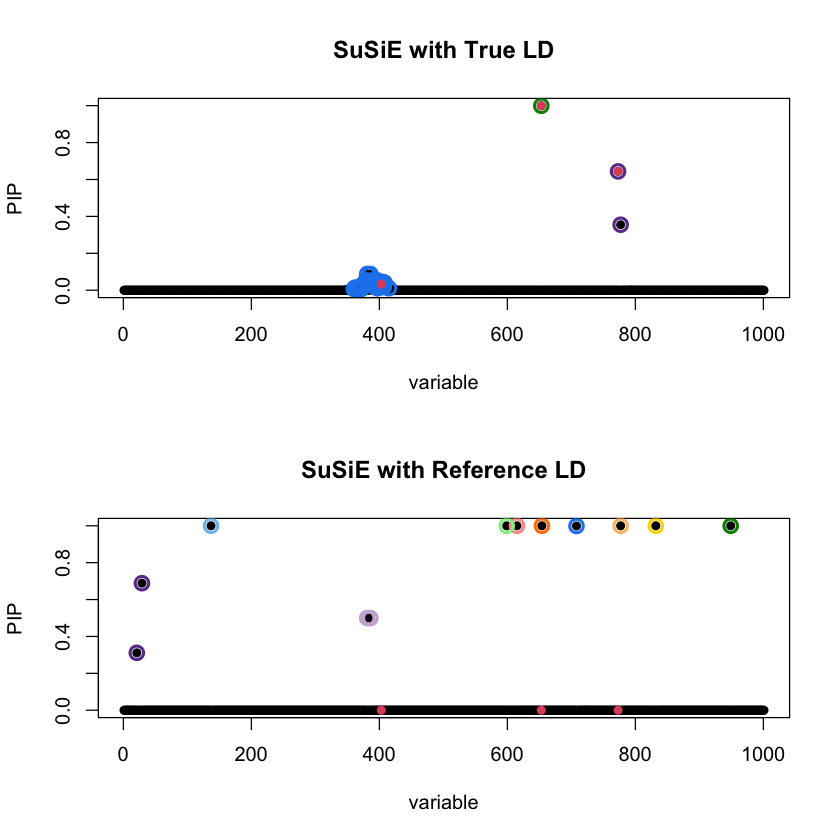

In [49]:
par(mfrow=c(2,1))
susie_plot(fitted_rss, y="PIP", b=b, main="SuSiE with True LD")
susie_plot(fitted_rss_ref, y="PIP", b=b, main="SuSiE with Reference LD")

Using the reference LD panel resulted in 9 false discoveries, where 9 SNPs were identified as credible set members but do not appear when using the correct LD matrix from genotype data. This suggests that fine-mapping accuracy can be compromised when LD is estimated from external populations, highlighting the importance of using study-specific LD whenever possible.

-------------------------------------------

We recommend the following modification to the LD matrix when reference panel ($R_{ref}$) are used,
$$
\tilde{R} = \text{cov2cor}((1-w)R_{ref}+ w zz^\intercal)),
$$
where z is the original summary statistics. We suggest using $w = 1/n_{ref}$, $n_{ref}$ is the sample size from the reference panel. The modified LD matrix becomes
$$
\tilde{R} = \text{cov2cor}(\frac{n_{ref}-1}{n_{ref}}R_{ref}+ \frac{1}{n_{ref}} zz^\intercal)) = \text{cov2cor}(\frac{1}{n_{ref}}(X_{ref}^\intercal X_{ref}+ zz^\intercal)),
$$
where `X_ref` is column-standardized. This modification is implemented in `susie_rss` with parameter `z_ld_weight`:



HINT: For large R or large XtX, consider installing the Rfast package for better performance.



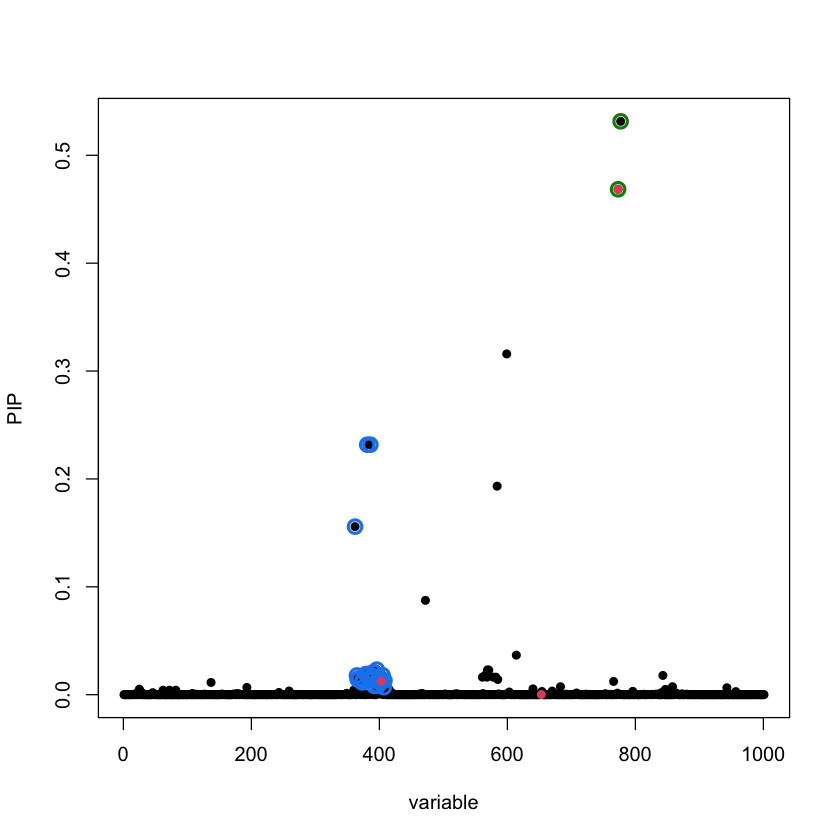

In [50]:
n_ref = 500
fitted_rss_ref_corrected <- susie_rss(z_scores, R_ref, z_ld_weight = 1/n_ref, L = 10)
susie_plot(fitted_rss_ref_corrected, y="PIP", b=b)

***
**Question 12: Please compare and comment on the results using adjusted reference LD panel. Is the result improved?**

In [51]:
cs_before <- fitted_rss$sets
cs_after <- fitted_rss_ref_corrected$sets

print(cs_before)  # Unadjusted LD CS
print(cs_after)   # Adjusted LD CS

false_discoveries <- setdiff(unlist(cs_before$cs), unlist(cs_after$cs))
print(false_discoveries)

$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 360 362 365 368 372 373 374 379 381 383 384 386 387 388 389 391 392 396 397
[20] 398 399 400 401 403 404 405 407 408 415


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8310851     0.9571059       0.9674829

$cs_index
[1] 2 1 3

$coverage
[1] 0.9993272 0.9986467 0.9508572

$requested_coverage
[1] 0.95

$cs
$cs$L1
[1] 773 777

$cs$L2
 [1] 362 365 366 367 368 373 374 379 381 383 384 386 387 388 389 391 392 396 398
[20] 399 400 403 404 405 407 408


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L1    0.9920949     0.9920949       0.9920949
L2    0.9434969     0.9909319       0.9977563

$cs_index
[1] 1 2

$coverage
[1] 0.9998887 0.9560874

$requested_coverage
[1] 0.95

[1] 653 360 372 397 401 415


**Answer:**
Yes, after adjusting the reference LD matrix, six SNPs (653, 360, 372, 397, 401, 415) were removed from the credible sets, indicating that they were false positives due to LD mismatch. The refined credible sets now contain fewer but more strongly correlated SNPs, leading to improved fine-mapping accuracy.

***

# Exercise: fine-mapping analysis on a different data-set

Please load and analyze another data-set provided in `susieR` package:

In [56]:
rm(list=ls())
library(susieR)
data(N2finemapping)

Please use the same R code for `N3finemapping` data to analyze this new data-set, similarly focusing on the first column of the phenotype matrix as the phenotype of interest. 
This data-set contains two true effect variables. However, as you are soon to find out in univariate linear regression analysis, **the lead SNP via univariate analysis is neither of the two effect variables**.

-------------------------------------------

**Question 13: please run `susie_rss` on the N2finemapping dataset and report the results below. Does it capture any true effect variant?**

**Answer:**

In [60]:
ls()
names(N2finemapping)
dim(X)
head(X)
y = Y[,1]
b = true_coef[,1]
which(b != 0)

[1] "b"             "N2finemapping" "y"

[1] "X"                 "chrom"             "pos"              
[4] "true_coef"         "residual_variance" "Y"                
[7] "allele_freq"       "V"

[1]  574 1002

0.7033313,-0.04181185,0.7264808,-0.4268293,0.8745645,-0.6282853,-0.1881533,0.8031359,-0.66387195,-0.015719,⋯,-0.5898361,-0.5898369,-0.4206037,-0.5915825,0.6236934,-0.5487805,-0.5918181,-0.5905923,-0.5898378,-0.5905923
0.7033313,-0.04181185,-0.2735192,0.5731707,0.8745645,0.3717147,-0.1881533,0.8031359,0.33612805,-0.015719,⋯,-0.5898361,-0.5898369,-0.4206037,-0.5915825,0.6236934,-0.5487805,-0.5918181,-0.5905923,-0.5898378,-0.5905923
-0.2966687,-0.04181185,-0.2735192,-0.4268293,-1.1254355,-0.6282853,-0.1881533,-0.1968641,-0.66387195,-0.015719,⋯,-0.5898361,-0.5898369,0.5793963,-0.5915825,0.6236934,-0.5487805,-0.5918181,-0.5905923,-0.5898378,-0.5905923
-0.2966687,-0.04181185,-0.2735192,-0.4268293,-0.1254355,-0.6282853,-0.1881533,-0.1968641,-0.66387195,-0.015719,⋯,-0.5898361,-0.5898369,0.5793963,-0.5915825,0.6236934,-0.5487805,-0.5918181,-0.5905923,-0.5898378,-0.5905923
0.7033313,0.95818815,-0.2735192,-0.4268293,-0.1254355,-0.6282853,-0.1881533,-0.1968641,-0.66387195,-0.015719,⋯,1.4101639,1.4101631,-0.4206037,1.4084175,-1.3763066,1.4512195,1.4081819,1.4094077,1.4101622,1.4094077
-0.2966687,-0.04181185,0.7264808,0.5731707,0.8745645,1.3717147,0.8118467,-0.1968641,0.02362805,-0.015719,⋯,0.4101639,0.4101631,0.5793963,0.4084175,-0.3763066,0.4512195,0.4081819,0.4094077,0.4101622,0.4094077


[1] 337 999

[1] -0.5357235  0.7524393


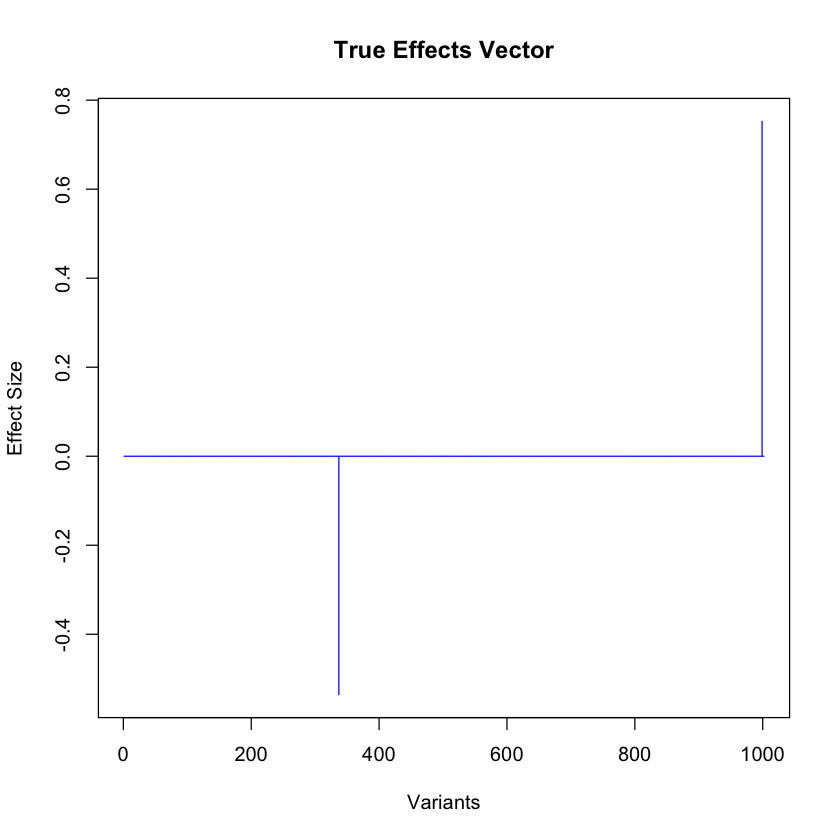

In [62]:
plot(b, type = "h", main = "True Effects Vector", xlab = "Variants", ylab = "Effect Size", col = "blue")
causal_indices <- which(b != 0)  # Indices of causal variants
effect_sizes <- b[causal_indices]
print(effect_sizes)

In [64]:
sumstats <- univariate_regression(X, y)

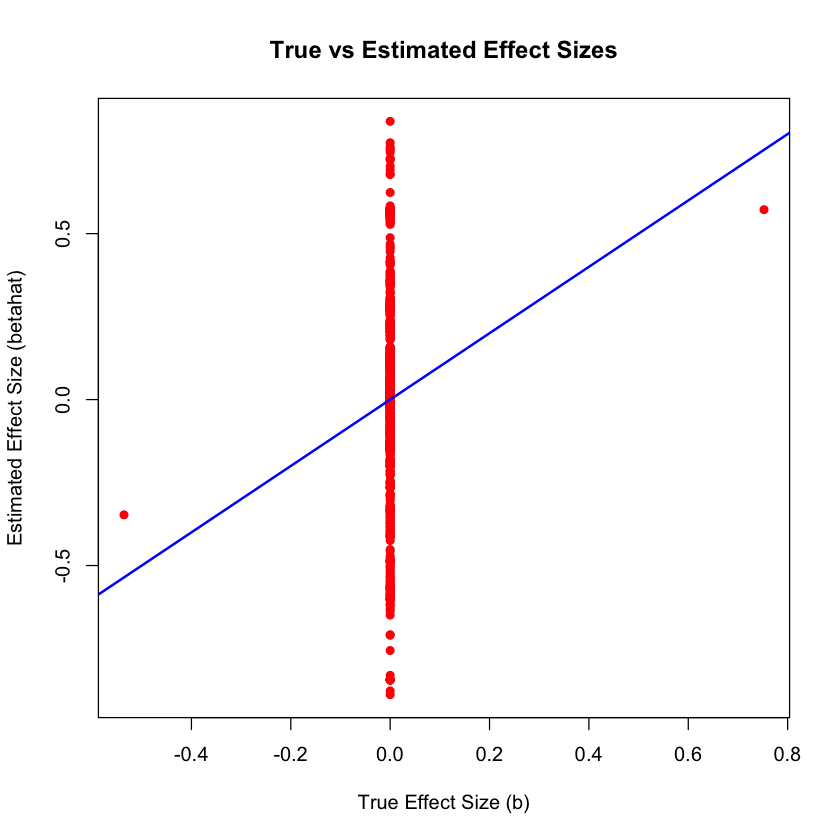

In [65]:
plot(b, sumstats$betahat, main = "True vs Estimated Effect Sizes",
     xlab = "True Effect Size (b)", ylab = "Estimated Effect Size (betahat)", col = "red", pch = 16)
abline(0,1, col="blue", lwd=2)  # Reference line

In [66]:
z_scores <- sumstats$betahat / sumstats$sebetahat
log10p <- -log10(pchisq(z_scores^2,1,lower.tail=F))

In [67]:
p_values <- pchisq(z_scores^2, 1, lower.tail=F)
significant_count <- sum(p_values < 5e-8)
print(significant_count)

[1] 133


In [72]:
significant_indices <- which(p_values < 5e-8)  # Find indices of significant SNPs
X_significant <- X[, significant_indices]  # Subset genotype matrix for these variants
cor_matrix <- cor(X_significant) # Compute pairwise correlations

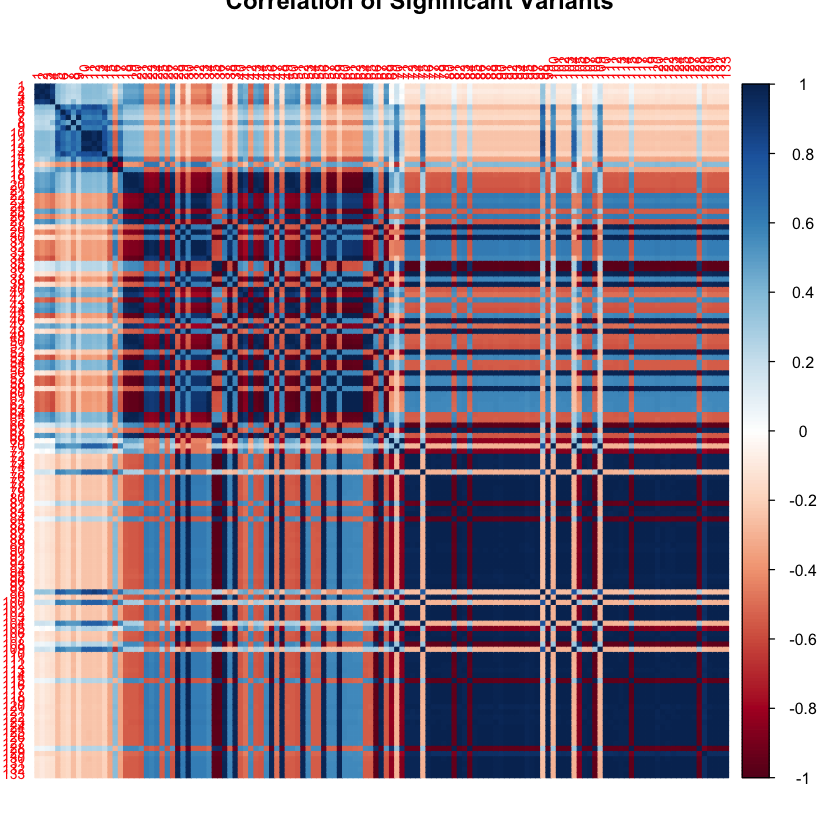

In [73]:
library(corrplot)
corrplot(cor_matrix, method = "color", tl.cex = 0.7, title = "Correlation of Significant Variants")
# Remove diagonal values and keep only upper triangle to avoid duplicate pairs
cor_matrix[lower.tri(cor_matrix, diag=TRUE)] <- NA 

In [74]:
# Find the pair with the highest correlation (excluding diagonal)
max_cor_indices <- which(cor_matrix == max(cor_matrix, na.rm=TRUE), arr.ind=TRUE)
print(max_cor_indices)  # SNP indices with highest correlation

      row col
 [1,]  37  39
 [2,]  48  52
 [3,]  38  62
 [4,]  49  65
 [5,]  48  67
 [6,]  52  67
 [7,]  77  86
 [8,]  77  88
 [9,]  86  88
[10,]  77  92
[11,]  86  92
[12,]  88  92
[13,]  77  93
[14,]  86  93
[15,]  88  93
[16,]  92  93
[17,]  77  97
[18,]  86  97
[19,]  88  97
[20,]  92  97
[21,]  93  97
[22,] 131 133


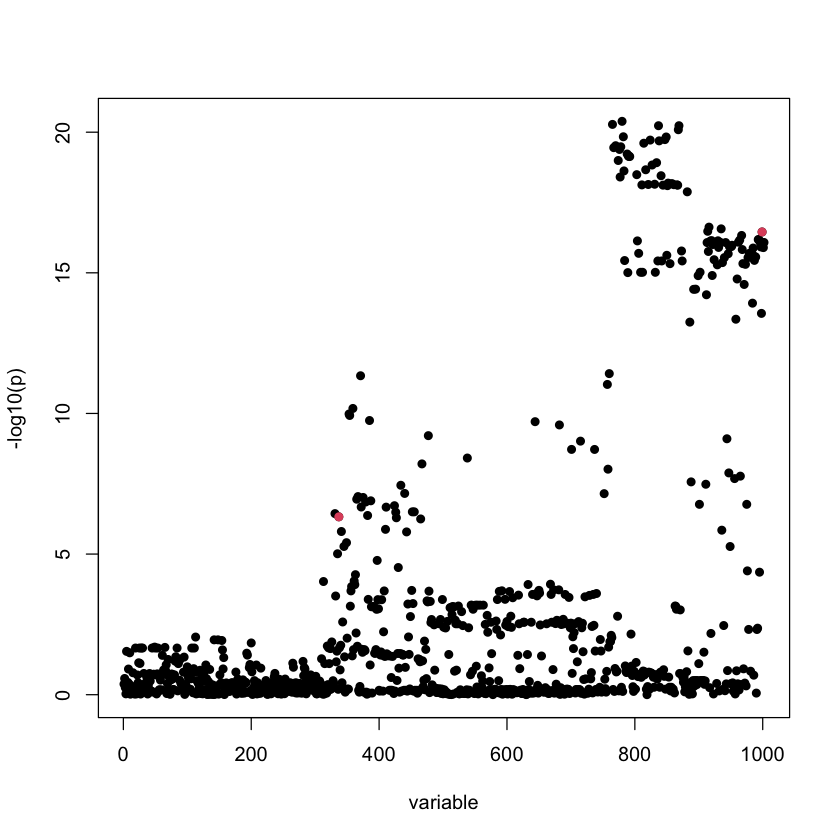

In [75]:
susie_plot(z_scores,y="z",b=b)

In [76]:
sorted_indices <- order(p_values)  # Sort SNPs by increasing p-value
lead_snp_index <- sorted_indices[1]  # Most significant SNP
second_snp_index <- sorted_indices[2]  # Second most significant SNP
print(second_snp_index)  # Output index of 2nd most significant SNP

[1] 765


In [77]:
causal_indices <- which(b != 0)  # Indices of true effect variables
is_causal <- second_snp_index %in% causal_indices
print(is_causal)  # TRUE or FALSE

[1] FALSE


In [78]:
lliks = sapply(1:ncol(X), function(i) logLik(lm(y~X[,i])))

In [79]:
lliks = lliks - max(lliks) # To avoid taking exp on large numbers in the next line, thus improving numerical stability 
probs = exp(lliks)/sum(exp(lliks))

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



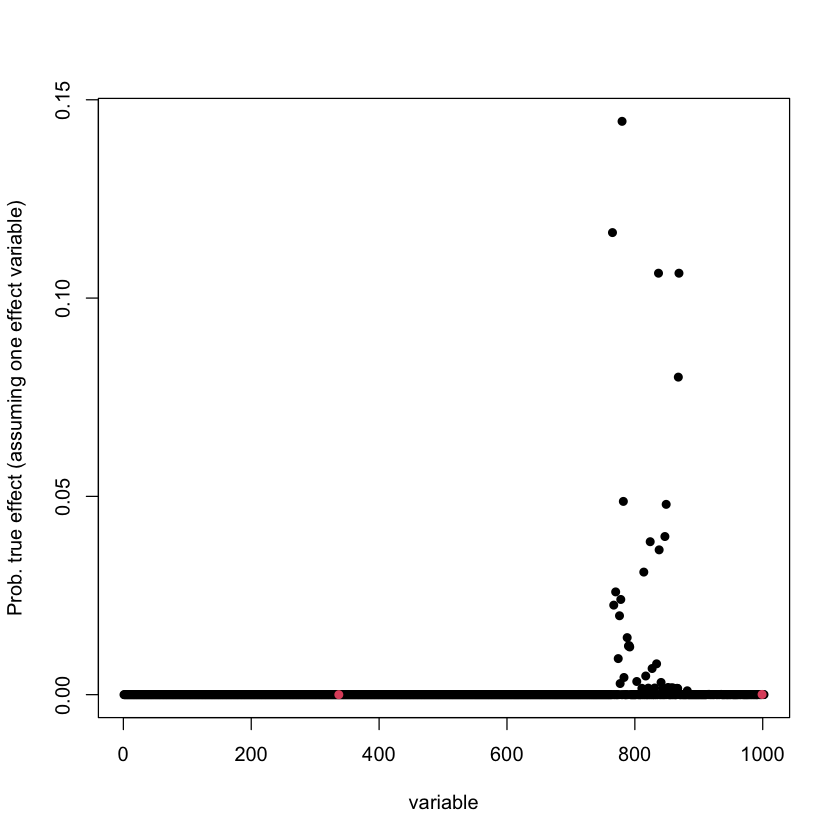

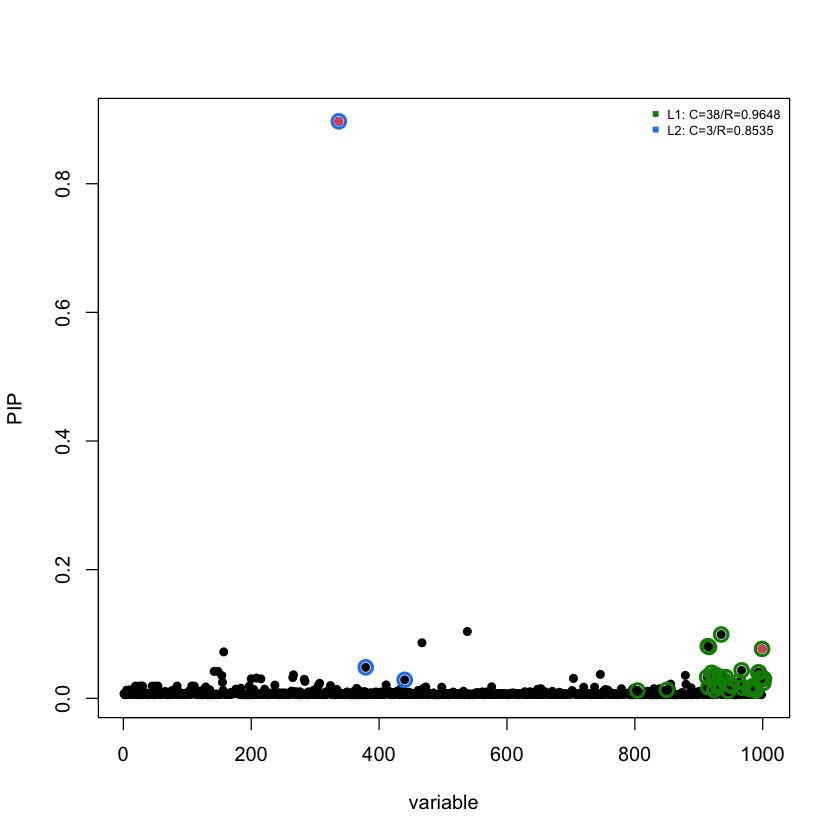

In [91]:
susie_plot(probs, y="PIP", b=b, ylab = "Prob. true effect (assuming one effect variable)")
fitted2 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.2)
susie_plot(fitted2, y='PIP', b=b, add_legend=T)

In [92]:
which(susieR:::in_CS(t(probs), coverage = 0.95) != 0)

[1] 765 767 770 774 776 778 780 782 788 790 791 792 814 824 834 837 838 847 849
[20] 868 869

In [93]:
R <- cor(X)

In [94]:
fitted_rss <- susie_rss(z_scores, R, L = 10)


HINT: For large R or large XtX, consider installing the Rfast package for better performance.



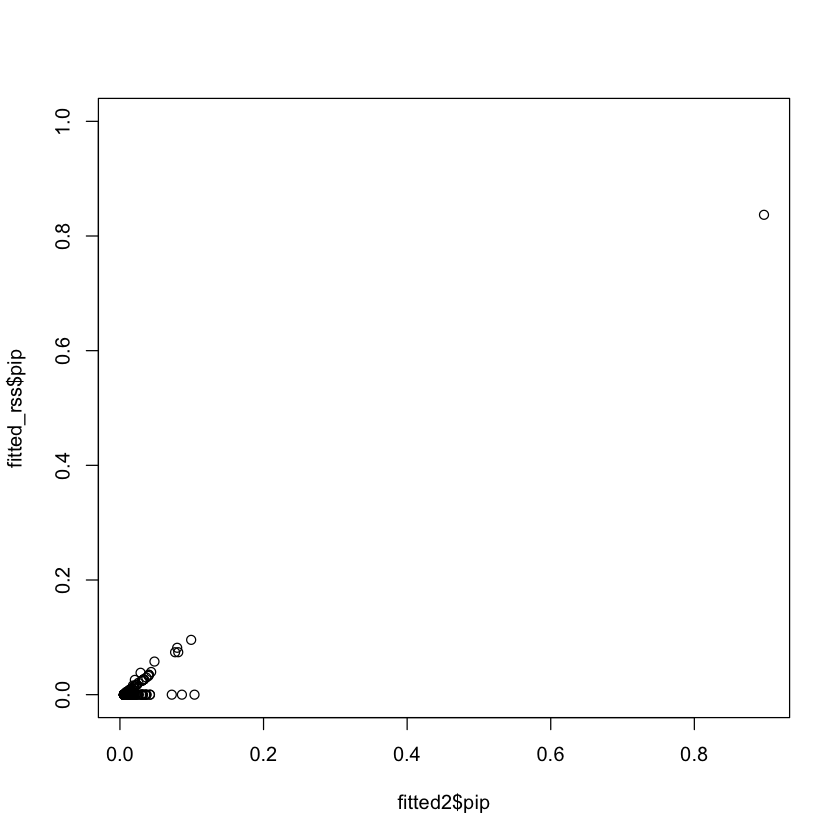

In [96]:
plot(fitted2$pip, fitted_rss$pip, ylim=c(0,1))

The SuSiE fine-mapping analysis reveals that while the univariate analysis identified a lead SNP, it is not one of the two true causal variants in the dataset. The posterior inclusion probability (PIP) plot highlights SNPs with high PIP, indicating stronger causal signals, which differ from the lead SNP found in univariate analysis. The correlation heatmap further suggests that LD structure may have influenced the univariate results, causing the lead SNP to be highly correlated with true causal variants without being directly causal. The Manhattan and -log10(p) plots confirm the presence of multiple strong association signals, but the credible sets identified by SuSiE point to different SNPs as likely causal variants. These findings emphasize the importance of fine-mapping techniques like SuSiE over simple univariate regression, as they account for LD structure and better isolate true causal variants from correlated but non-causal SNPs.